# Pytorch Lightning Example - MNIST

In [34]:
#!pip install pytorch-lightning

In [35]:
import sys
from os import cpu_count
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST 
import pytorch_lightning as pl
from torchmetrics.functional import accuracy

plt.style.use('seaborn')
pl.seed_everything(42)

Global seed set to 42


42

## Model

In [46]:
class PtImageClassifier(nn.Module):
    def __init__(self, channel, height, width, num_classes):
        super().__init__()
        self.channel = channel
        self.height = height
        self.width = width       
        
        # Model layers
        self.layer1 = nn.Linear(in_features=channel*width*height, 
                                out_features=256)
        self.relu1 = nn.ReLU()
        self.do1 = nn.Dropout(p=0.25)
        self.layer2 = nn.Linear(in_features=256, 
                                out_features=64)
        self.relu2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.25)
        self.layer3 = nn.Linear(in_features=64, 
                                out_features=num_classes)
            
    def forward(self, x):
        # flatten the input
        x = x.view(x.shape[0], -1)
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.do1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.do2(x)
        out = self.layer3(x)
        return out
    

class LitImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.metrics_ = {'train': {
                                  'batch': {'loss':[], 'acc':[]}, 
                                  'epoch':{'loss':[], 'acc':[]}
                                 }, 
                         'val': {
                                  'batch': {'loss':[], 'acc':[]}, 
                                  'epoch':{'loss':[], 'acc':[]}
                                }, 
                         'test': {
                                  'batch': {'loss':[], 'acc':[]}, 
                                  'epoch':{'loss':[], 'acc':[]}
                                }                          
                        }

        self.__curr_epoch = 0
        self.__n_train_batches = 0
        self.__n_val_batches = 0
        self.__n_test_batches = 0
                  
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
            
    def __step(self, batch):
        x, y = batch
        # Get model output as raw logits
        logits = self.model(x) # calls forward 
        # Compute loss and accuracy
        loss = self.criterion(logits, y)
        acc = accuracy(F.softmax(logits, dim=-1), y)   
        return loss, acc

    def on_training_start(self):
        sys.stdout.flush()
        print()

    def training_step(self, batch, batch_idx):
        self.__n_train_batches = batch_idx
        # Feed forward and get loss and metrics
        loss, acc = self.__step(batch)
        # store batch loss and accuracy
        l = loss.detach().item()
        a = acc.detach().item()
        self.metrics_['train']['batch']['loss'].append(l)
        self.metrics_['train']['batch']['acc'].append(a)
        # print the running status
        sys.stdout.write(f'\rTraining Epoch   [{self.__curr_epoch+1:4d}] ==> train_loss: {l:.8f}, train_acc: {a*100:.2f}% ({batch_idx})')        
        return {'loss': loss}

    def on_validation_start(self):
        sys.stdout.flush()
        print()

    def validation_step(self, batch, batch_idx):
        self.__n_val_batches = batch_idx
        # Feed forward and get loss and metrics        
        loss, acc = self.__step(batch)
        # store batch loss and accuracy
        l = loss.detach().item()
        a = acc.detach().item()
        self.metrics_['val']['batch']['loss'].append(l)
        self.metrics_['val']['batch']['acc'].append(a)
        # print the running status
        sys.stdout.write(f'\rValidating Epoch [{self.__curr_epoch+1:4d}] ==> val_loss  : {l:.8f}, val_acc  : {a*100:.2f}% ({batch_idx})')
        return {'loss': loss}

    def __compute_epoch_metric(self, s=None, m=None, n=0, e=0):
        start_idx = e * n + 1
        end_idx = start_idx + n + 1
        batch_m = self.metrics_[s]['batch'][m][start_idx:end_idx]
        epoch_m = sum(batch_m)/len(batch_m)
        return epoch_m

    def training_epoch_end(self, outputs):
        print()
        # compute this epoch's metrics
        # get batch level metrics for this epoch and compute average
        # train 
        loss = self.__compute_epoch_metric('train', 'loss', 
                                            self.__n_train_batches,
                                            self.__curr_epoch)
        self.metrics_['train']['epoch']['loss'].append(loss)
        acc = self.__compute_epoch_metric('train', 'acc', 
                                          self.__n_train_batches,
                                          self.__curr_epoch)
        self.metrics_['train']['epoch']['acc'].append(acc)

        # val 
        loss = self.__compute_epoch_metric('val', 'loss', 
                                            self.__n_val_batches,
                                            self.__curr_epoch)
        self.metrics_['val']['epoch']['loss'].append(loss)
        acc = self.__compute_epoch_metric('val', 'acc', 
                                            self.__n_val_batches,
                                            self.__curr_epoch)
        self.metrics_['val']['epoch']['acc'].append(acc)

        # prepare for next epoch
        self.__curr_epoch += 1
        self.__n_train_batches = 0
        self.__n_val_batches = 0

    def test_step(self, batch, batch_idx):
        self.__n_test_batches = batch_idx
        # Feed forward and get loss and metrics
        loss, acc = self.__step(batch)
        # store batch loss and accuracy
        l = loss.detach().item()
        a = acc.detach().item()
        self.metrics_['test']['batch']['loss'].append(l)
        self.metrics_['test']['batch']['acc'].append(a)
        # print the running status
        sys.stdout.write(f'\rTesting ==> test_acc: {a*100:.2f}% ({batch_idx})')        
        return {'loss': loss}

    def test_epoch_end(self, outputs):
        print()
        # compute this epoch's metrics
        # get batch level metrics for this epoch and compute average
        # train 
        loss = self.__compute_epoch_metric('test', 'loss', 
                                            self.__n_test_batches,
                                            0)
        self.metrics_['test']['epoch']['loss'].append(loss)
        acc = self.__compute_epoch_metric('test', 'acc', 
                                          self.__n_test_batches,
                                          0)
        self.metrics_['test']['epoch']['acc'].append(acc)


    # Optimizer
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-2)

    def metrics(self, stage='train', level='batch'):
        return pd.DataFrame(self.metrics_[stage][level])

## Data

In [37]:
class ImageDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
    
    # Download and preprocess (read/write to disk etc)
    def prepare_data(self):
        MNIST(root='data', train=True, download=True)
        MNIST(root='data', train=False, download=True)
    
    # Prepare datasets, train, val test splits
    def setup(self, stage=None):
        self.train_ds = MNIST(root='data', train=True, download=False,transform=transforms.ToTensor())
        self.test_ds = MNIST(root='data', train=False, download=False,transform=transforms.ToTensor())
        # split train_ds into train (80%) and val (20%) sets
        self.train_ds, self.val_ds = random_split(dataset=self.train_ds,lengths=[48000, 12000])
        
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=32, shuffle=True, num_workers=cpu_count())
    
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=32, shuffle=False, num_workers=cpu_count())
    
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=32, shuffle=False, num_workers=cpu_count())

## Training

In [47]:
model = PtImageClassifier(channel=1, width=28, height=28, num_classes=10)
lit_model = LitImageClassifier(model)
dm = ImageDataModule()
trainer = pl.Trainer(max_epochs=5, enable_progress_bar=False, gpus=1)
trainer.fit(lit_model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | PtImageClassifier | 218 K 
1 | criterion | CrossEntropyLoss  | 0     
------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.872     Total estimated model params size (MB)


Global seed set to 42


Training Epoch   [   1] ==> train_loss: 0.60012072, train_acc: 87.50% (1499)
Validating Epoch [   1] ==> val_loss  : 0.01140810, val_acc  : 100.00% (374)
Training Epoch   [   2] ==> train_loss: 0.17804669, train_acc: 93.75% (1499)
Validating Epoch [   2] ==> val_loss  : 0.03441199, val_acc  : 100.00% (374)
Training Epoch   [   3] ==> train_loss: 0.20619158, train_acc: 93.75% (1499)
Validating Epoch [   3] ==> val_loss  : 0.04075401, val_acc  : 96.88% (374)
Training Epoch   [   4] ==> train_loss: 0.33818945, train_acc: 87.50% (1499)
Validating Epoch [   4] ==> val_loss  : 0.31089649, val_acc  : 96.88% (374)
Training Epoch   [   5] ==> train_loss: 0.26175928, train_acc: 90.62% (1499)
Validating Epoch [   5] ==> val_loss  : 0.08255085, val_acc  : 96.88% (374)


In [39]:
# Extract metrics
train_batch_losses = lit_model.metrics(stage='train', level='batch')['loss']
val_batch_losses = lit_model.metrics(stage='val', level='batch')['loss']
train_batch_acc = lit_model.metrics(stage='train', level='batch')['acc']
val_batch_acc = lit_model.metrics(stage='val', level='batch')['acc']

train_epoch_losses = lit_model.metrics(stage='train', level='epoch')['loss']
val_epoch_losses = lit_model.metrics(stage='val', level='epoch')['loss']
train_epoch_acc = lit_model.metrics(stage='train', level='epoch')['acc']
val_epoch_acc = lit_model.metrics(stage='val', level='epoch')['acc']

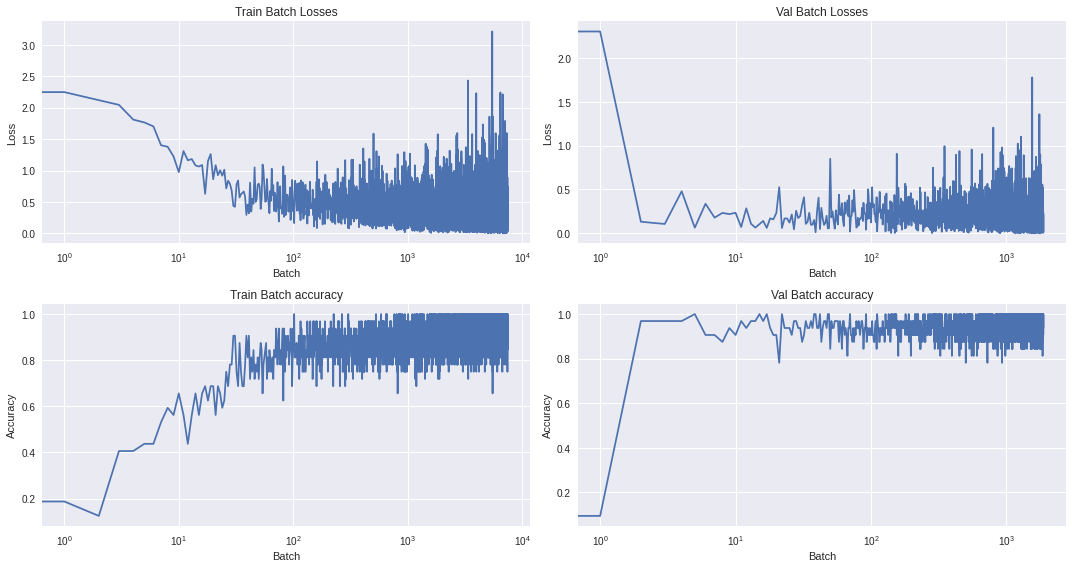

In [40]:
# Plot batch metrics
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
train_batch_losses.plot(kind='line', xlabel='Batch', ylabel='Loss', title='Train Batch Losses', logx=True)
plt.subplot(2, 2, 2)
val_batch_losses.plot(kind='line', xlabel='Batch', ylabel='Loss', title='Val Batch Losses', logx=True)
plt.subplot(2, 2, 3)
train_batch_acc.plot(kind='line', xlabel='Batch', ylabel='Accuracy', title='Train Batch accuracy', logx=True)
plt.subplot(2, 2, 4)
val_batch_acc.plot(kind='line', xlabel='Batch', ylabel='Accuracy', title='Val Batch accuracy', logx=True)
plt.tight_layout()
plt.show()

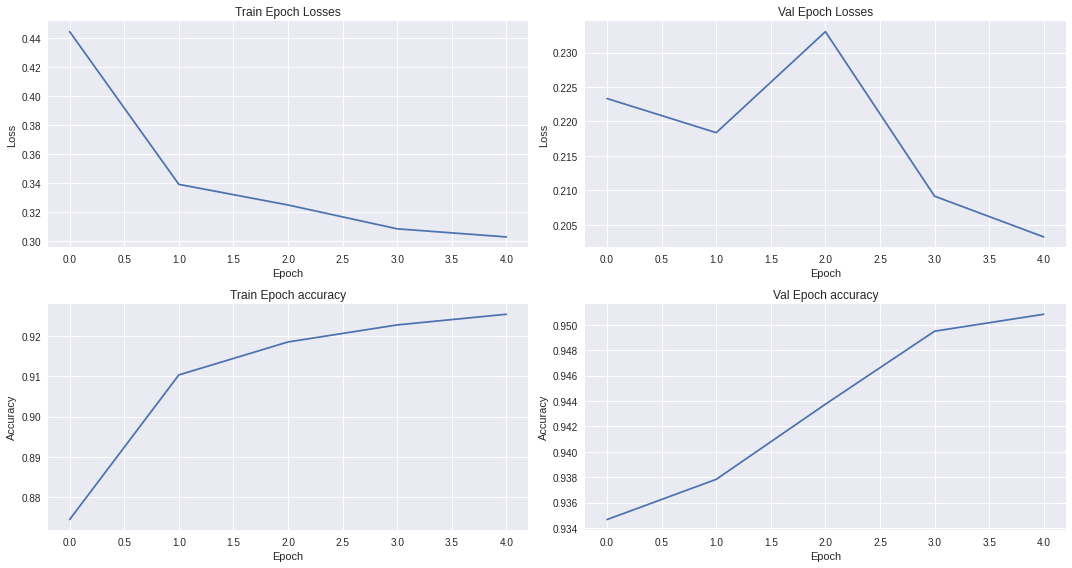

In [41]:
# Plot epoch metrics
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
train_epoch_losses.plot(kind='line', xlabel='Epoch', ylabel='Loss', title='Train Epoch Losses')
plt.subplot(2, 2, 2)
val_epoch_losses.plot(kind='line', xlabel='Epoch', ylabel='Loss', title='Val Epoch Losses')
plt.subplot(2, 2, 3)
train_epoch_acc.plot(kind='line', xlabel='Epoch', ylabel='Accuracy', title='Train Epoch accuracy')
plt.subplot(2, 2, 4)
val_epoch_acc.plot(kind='line', xlabel='Epoch', ylabel='Accuracy', title='Val Epoch accuracy')
plt.tight_layout()
plt.show()

## Evaluation

In [48]:
trainer.test(lit_model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing ==> test_acc: 100.00% (312)
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]